In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime
from datetime import date
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display
from matplotlib.ticker import FuncFormatter
import sklearn.tree as tree
import collections
%matplotlib inline

/Applications/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import pickle
import seaborn as sns
plt.style.use('seaborn')
with open('aggregate_data.p', 'rb') as f:
    data = pickle.load(f)
    data = pd.DataFrame(data)

#impute missings with mean
#cols_with_missing = pd.isnull(x_train_cons).sum(axis=0)
#print(cols_with_missing)
category_means = data.groupby('category').mean()

tmp = data.join(category_means, rsuffix = '_category_mean', on = 'category')
means = tmp[[x+'_category_mean' for x in data.columns if x not in ['category', 'featured','num_tracks','num_followers']]]
means.columns = [x.split('_category_mean')[0] for x in means.columns]
data = data.fillna(means)
data = data.fillna(data.mean())


#drop vars that make no sense

columns = ['acousticness_max', 'acousticness_mean', 'acousticness_median', 'acousticness_min', 'acousticness_sd', 
'category', 'danceability_max', 'danceability_mean', 'danceability_median', 'danceability_min', 
'danceability_sd', 'duration_ms_max', 'duration_ms_mean', 'duration_ms_median', 'duration_ms_min', 
'duration_ms_sd', 'energy_max', 'energy_mean', 'energy_median', 'energy_min', 'energy_sd', 'featured',
'instrumentalness_max', 'instrumentalness_mean', 'instrumentalness_median', 'instrumentalness_min', 
'instrumentalness_sd', 'key_mode', 'liveness_max', 'liveness_mean', 'liveness_median', 'liveness_min', 
'liveness_sd', 'loudness_max', 'loudness_mean', 'loudness_median', 'loudness_min', 'loudness_sd', 
'mode_mean', 'mode_median', 'mode_mode', 'available_markets_max', 'available_markets_mean', 
           'available_markets_median', 'available_markets_min', 'available_markets_sd', 'popularity_max', 
'popularity_mean', 'popularity_median', 'popularity_min', 'popularity_sd', 'speechiness_max', 
'speechiness_mean', 'speechiness_median', 'speechiness_min', 'speechiness_sd', 'tempo_max', 'tempo_mean', 
'tempo_median', 'tempo_min', 'tempo_sd', 'time_signature_mode', 'valence_max', 'valence_mean', 
'valence_median', 'valence_min', 'valence_sd', 'artist_famil_max', 'artist_famil_mean', 
'artist_famil_median', 'artist_famil_min', 'artist_famil_sd', 'artist_hot_max', 
'artist_hot_mean', 'artist_hot_median', 'artist_hot_min', 'artist_hot_sd', 
'song_hot_max', 'song_hot_mean', 'song_hot_median', 'song_hot_min', 
'song_hot_sd', 'num_followers'
          , 'num_tracks'
          ]

not_overlap = [x for x in columns if x not in data.columns]


data = data[columns]



# create dummies for category
def create_categorical_vars(data):
    categorical = ['category']
    dummies = {}
    for var in categorical:
        dummies[var] = pd.get_dummies(data[var], prefix = var)
        cols_to_keep = dummies[var].columns[0:len(dummies[var].columns)-1]
        data = data.join(dummies[var][cols_to_keep])
        data = data.drop(var, 1)
    return data

data = create_categorical_vars(data)



#split into train / test to avoid cheating
np.random.seed(1234)
train_pct = .5
msk = np.random.uniform(0,1,len(data)) < train_pct
train = data.loc[msk, :]
test = data.loc[~msk, :]

In [3]:
train.head()

,acousticness_max,acousticness_mean,acousticness_median,acousticness_min,acousticness_sd,danceability_max,danceability_mean,danceability_median,danceability_min,danceability_sd,...,category_pop,category_popculture,category_punk,category_reggae,category_rock,category_romance,category_sleep,category_soul,category_toplists,category_travel
37i9dQZF1DWSBRKlyNxSuy,0.985,0.904500,0.9440,0.623000,0.083575,0.540,0.442917,0.4635,0.2890,0.065845,...,0,0,0,0,0,0,0,0,0,0
37i9dQZF1DWSIcimvN18p3,0.994,0.649742,0.7090,0.013200,0.277198,0.813,0.537625,0.5260,0.2190,0.133520,...,0,0,0,0,0,0,0,0,0,0
37i9dQZF1DWSNNoRF9meHq,0.989,0.916120,0.9340,0.643000,0.069801,0.237,0.117402,0.1115,0.0611,0.042378,...,0,0,0,0,0,0,0,0,0,0
37i9dQZF1DWSNmwgf7Nv11,0.979,0.490855,0.4705,0.000552,0.306968,0.831,0.527132,0.5335,0.1990,0.138828,...,0,0,0,0,0,0,0,0,0,0
37i9dQZF1DWSRoT7QRAibZ,0.937,0.736114,0.8045,0.055500,0.207173,0.897,0.560451,0.5460,0.3380,0.119142,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test.head()

,acousticness_max,acousticness_mean,acousticness_median,acousticness_min,acousticness_sd,danceability_max,danceability_mean,danceability_median,danceability_min,danceability_sd,...,category_pop,category_popculture,category_punk,category_reggae,category_rock,category_romance,category_sleep,category_soul,category_toplists,category_travel
37i9dQZF1DWSDoVybeQisg,0.882,0.261093,0.20100,0.000242,0.235758,0.684,0.393732,0.3980,0.156,0.122645,...,0,0,0,0,1,0,0,0,0,0
37i9dQZF1DWSJHnPb1f0X3,0.491,0.093987,0.05495,0.001760,0.112922,0.836,0.684959,0.6870,0.409,0.086818,...,0,0,0,0,0,0,0,0,0,0
37i9dQZF1DWSKpvyAAcaNZ,0.955,0.174686,0.06580,0.000009,0.238388,0.806,0.506744,0.5350,0.246,0.138378,...,0,0,0,0,0,0,0,0,0,0
37i9dQZF1DWSOkubnsDCSS,0.671,0.188856,0.14150,0.001700,0.162775,0.895,0.690434,0.7015,0.417,0.134916,...,0,0,0,0,0,0,0,0,0,0
37i9dQZF1DWSPfT00faDTn,0.983,0.611544,0.67700,0.001300,0.285523,0.939,0.570000,0.5610,0.196,0.152046,...,0,0,0,0,0,0,0,0,0,0


In [7]:
to_y_train = np.log(train['num_followers'].astype(float))
to_y_test = np.log(test['num_followers'].astype(float))
to_x_train = train[[x for x in train.columns if x != 'num_followers']]
to_x_test = test[[x for x in test.columns if x != 'num_followers']]

In [8]:
#Standardize
#train_means_and_sds = {}
continuous_variables = [x for x in to_x_train.columns if 'category' not in x and x != 'available_markets_max' and x != 'featured']
non_continuous_variables = [x for x in to_x_train.columns if 'category' in x]

def standardize_data(data, train):
        return (data - train.mean()) / train.std()


x_train_cont = standardize_data(to_x_train[continuous_variables], to_x_train[continuous_variables])
x_test_cont = standardize_data(to_x_test[continuous_variables], to_x_train[continuous_variables])

x_train_std = x_train_cont.join(to_x_train[non_continuous_variables])
x_test_std = x_test_cont.join(to_x_test[non_continuous_variables])

x_train_std2 = x_train_std.join(to_x_train['available_markets_max'])
x_test_std2 = x_test_std.join(to_x_test['available_markets_max'])

x_train_std3 = x_train_std2.join(to_x_train['featured'])
x_test_std3 = x_test_std2.join(to_x_test['featured'])


y_train = standardize_data(to_y_train, to_y_train).astype(float)
y_test = standardize_data(to_y_test, to_y_train).astype(float)

In [9]:
x_train_const = sm.tools.add_constant(x_train_std3, has_constant = 'add')
x_test_const = sm.tools.add_constant(x_test_std3, has_constant = 'add')

In [10]:
#Let's think more about which vars to include
to_drop = ['acousticness_max',  'acousticness_median', 'acousticness_min', 'danceability_max',  'danceability_median', 'danceability_min', 
'duration_ms_max',  'duration_ms_median', 'duration_ms_min', 'energy_max', 'energy_median', 'energy_min', 
'instrumentalness_max', 'instrumentalness_median', 'instrumentalness_min', 'liveness_max',  'liveness_median', 
'liveness_min', 'loudness_max', 'loudness_median', 'loudness_min','mode_mean', 'mode_median', 
'available_markets_max','available_markets_median', 'available_markets_min', 'popularity_median', 
'popularity_min', 'speechiness_max', 'speechiness_median', 'speechiness_min', 'tempo_max','tempo_median', 
'tempo_min', 'time_signature_mode', 'valence_max', 'valence_median', 'valence_min', 'artist_famil_max', 
'artist_famil_median', 'artist_famil_min', 'artist_hot_max', 
 'artist_hot_median', 'artist_hot_min', 
'song_hot_max', 'song_hot_median', 'song_hot_min']

x_train = x_train_const.drop(to_drop, axis=1)
x_test = x_test_const.drop(to_drop, axis=1)


In [13]:
regression = OLS(y_train, x_train).fit()
ols_train_preds = regression.predict(x_train)
ols_test_preds = regression.predict(x_test)
print('Train R^2: {rsq}'.format(rsq = regression.rsquared))
print('Train BIC: {bic}'.format(bic = regression.bic))
print('Test R^2: ', r2_score(y_test, ols_test_preds))
#regression.summary()

Train R^2: 0.5621439417922931
Train BIC: 1066.1680987155785
Test R^2:  0.303403795346


In [12]:
#LASSO
lasso_model = LassoCV(alphas = [10**i for i in (-5,-4,-3,-2,-1,0,1,2,3,4,5)], fit_intercept = False, tol = 0.01)
lasso_fitted = lasso_model.fit(x_train, y_train)
print("Train R2", lasso_fitted.score(x_train, y_train))
print("Test R2", lasso_fitted.score(x_test, y_test))
pd.Series(lasso_model.coef_, index = x_train.columns)

Train R2 0.491569481115
Test R2 0.325515614121


const                      0.087827
acousticness_mean          0.000000
acousticness_sd            0.078522
danceability_mean          0.015949
danceability_sd           -0.025545
duration_ms_mean           0.016489
duration_ms_sd             0.004517
energy_mean                0.000000
energy_sd                 -0.063053
instrumentalness_mean      0.015758
instrumentalness_sd        0.063147
key_mode                  -0.000000
liveness_mean              0.002489
liveness_sd                0.000000
loudness_mean             -0.000000
loudness_sd                0.000000
mode_mode                 -0.055253
available_markets_mean    -0.048225
available_markets_sd       0.160470
popularity_max            -0.096544
popularity_mean            0.679687
popularity_sd              0.022512
speechiness_mean           0.012941
speechiness_sd            -0.000000
tempo_mean                 0.035863
tempo_sd                  -0.000000
valence_mean              -0.004493
valence_sd                -0

In [14]:
#Ridge
ridge_model = RidgeCV(alphas = [10**i for i in (-5,-4,-3,-2,-1,0,1,2,3,4,5)], fit_intercept = False)
ridge_fitted = ridge_model.fit(x_train, y_train)
print("Train R2", ridge_fitted.score(x_train, y_train))
print("Test R2", ridge_fitted.score(x_test, y_test))
pd.Series(ridge_model.coef_, index = x_train.columns)

Train R2 0.558018998229
Test R2 0.31182299033


const                      0.034160
acousticness_mean          0.130132
acousticness_sd            0.222815
danceability_mean          0.103260
danceability_sd           -0.026571
duration_ms_mean           0.099280
duration_ms_sd            -0.015643
energy_mean                0.165377
energy_sd                 -0.179710
instrumentalness_mean      0.023256
instrumentalness_sd        0.095248
key_mode                  -0.023768
liveness_mean              0.039376
liveness_sd               -0.004025
loudness_mean             -0.197089
loudness_sd               -0.007543
mode_mode                 -0.049869
available_markets_mean    -0.051055
available_markets_sd       0.155659
popularity_max            -0.180769
popularity_mean            0.848093
popularity_sd              0.090733
speechiness_mean           0.017621
speechiness_sd            -0.013415
tempo_mean                 0.160158
tempo_sd                   0.054726
valence_mean              -0.081561
valence_sd                 0

In [15]:
#CLASSIFICATION MODELS!!


#Let's split our dependent var into quartiles
data['num_followers_quantile'] = pd.qcut(data['num_followers'], 5, labels=False)
quantiles = data['num_followers_quantile']

In [16]:
x_train_class = x_train
x_test_class = x_test
y_train_class = pd.concat([y_train, quantiles], axis=1, join_axes=[y_train.index]).drop('num_followers', axis = 1).values.ravel()
y_test_class = pd.concat([y_test, quantiles], axis=1, join_axes=[y_test.index]).drop('num_followers', axis = 1).values.ravel()

In [17]:
def calculate_cr(classifications, y):
    correct = classifications == y
    cr = correct.sum()/len(correct)
    return cr

In [18]:
#Multinomial Logistic
logistic_regression_mn = LogisticRegressionCV(Cs=10, multi_class='multinomial').fit(x_train_class, y_train_class)
logistic_classifications_train_mn = logistic_regression_mn.predict(x_train_class)
logistic_classifications_test_mn = logistic_regression_mn.predict(x_test_class)
#print(logistic_classifications_train_mn.shape)
#print(y_train_class)
print("Multinomial Logistic Regression")
print("\tTrain CR:", str(calculate_cr(logistic_classifications_train_mn, y_train_class)))
print("\tTest CR:", str(calculate_cr(logistic_classifications_test_mn, y_test_class)))

#OvR Logistic Reg
logistic_regression_ovr = LogisticRegressionCV(Cs=10, multi_class='ovr').fit(x_train_class, y_train_class)
logistic_classifications_train_ovr = logistic_regression_ovr.predict(x_train_class)
logistic_classifications_test_ovr = logistic_regression_ovr.predict(x_test_class)

print("OvR Logistic Regression")
print("\tTrain CR:", str(calculate_cr(logistic_classifications_train_ovr, y_train_class)))
print("\tTest CR:", str(calculate_cr(logistic_classifications_test_ovr, y_test_class)))


Multinomial Logistic Regression
	Train CR: 0.52994011976
	Test CR: 0.338888888889
OvR Logistic Regression
	Train CR: 0.505988023952
	Test CR: 0.355555555556


In [19]:
#LDA
lda = LinearDiscriminantAnalysis().fit(x_train_class, y_train_class)
lda_classifications_train = lda.predict(x_train_class)
lda_classifications_test = lda.predict(x_test_class)

print("LDA")
print("\tTrain CR:", str(calculate_cr(lda_classifications_train, y_train_class)))
print("\tTest CR:", str(calculate_cr(lda_classifications_test, y_test_class)))


#QDA
qda = QuadraticDiscriminantAnalysis().fit(x_train_class, y_train_class);
qda_classifications_train = qda.predict(x_train_class)
qda_classifications_test = qda.predict(x_test_class)


print("QDA")
print("\tTrain CR:", str(calculate_cr(qda_classifications_train, y_train_class)))
print("\tTest CR:", str(calculate_cr(qda_classifications_test, y_test_class)))

LDA
	Train CR: 0.655688622754
	Test CR: 0.355555555556
QDA
	Train CR: 0.586826347305
	Test CR: 0.244444444444


/Applications/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Applications/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


CV Choice of Max Depth: 3
	Train CR: 0.431137724551
	Test CR: 0.333333333333


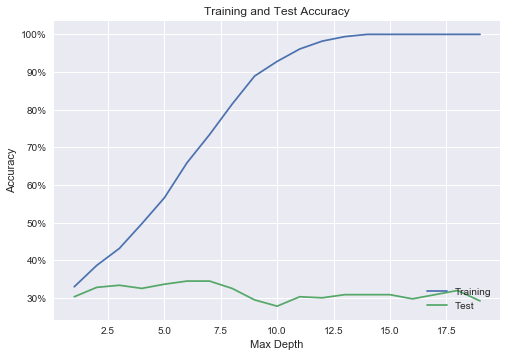

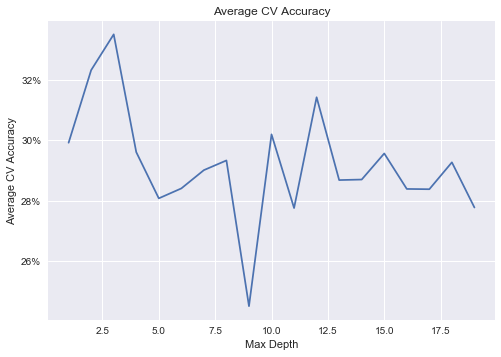

In [20]:
#Decision Trees
from sklearn.tree import DecisionTreeClassifier, DecisionTreeClassifier
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import cross_val_score
import sklearn.tree as tree
import collections

depth = range(1,20)
train_accuracy = []
test_accuracy = []
for i in depth:
    classifier = DecisionTreeClassifier(max_depth = i)
    classifier.fit(x_train_class, y_train_class)
    classifications_train = classifier.predict(x_train_class)
    classifications_test = classifier.predict(x_test_class)
    train_accuracy.append(calculate_cr(classifications_train, y_train_class))
    test_accuracy.append(calculate_cr(classifications_test, y_test_class))
    
# Plot the above classification accuracies
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(depth, train_accuracy)
plt.plot(depth, test_accuracy)
plt.title('Training and Test Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Test'], loc = 'lower right')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# Find best max depth via CV
avg_cv_scores = []
for i in depth:
    classifier = DecisionTreeClassifier(max_depth = i)
    cv_scores = cross_val_score(classifier, x_train_class, y_train_class, cv=5)
    avg_cv_scores.append(np.mean(cv_scores))
avg_cv_scores = np.array(avg_cv_scores)

# Plot CV scores
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(depth, avg_cv_scores)
plt.title('Average CV Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Average CV Accuracy')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
print('CV Choice of Max Depth: ' + str(avg_cv_scores.argmax()+1))
#print("Max Depth = 2")
print("\tTrain CR:", str(train_accuracy[avg_cv_scores.argmax()]))
print("\tTest CR:", str(test_accuracy[avg_cv_scores.argmax()]))




         Train      Test
2     0.362275  0.336111
4     0.383234  0.277778
8     0.422156  0.266667
16    0.511976  0.350000
32    0.491018  0.352778
64    0.562874  0.330556
128   0.550898  0.363889
256   0.589820  0.375000
512   0.586826  0.366667
1024  0.601796  0.355556
2048  0.595808  0.366667
4096  0.589820  0.355556


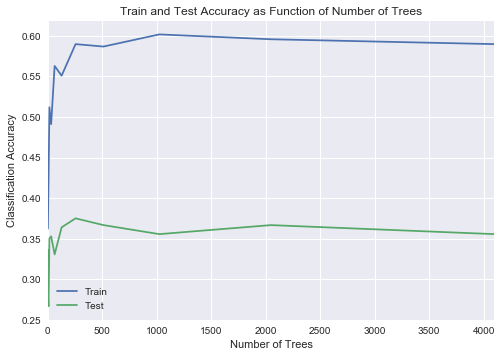

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
num_trees = [2**i for i in [1,2,3,4,5,6,7,8, 9, 10, 11, 12]]
train_accs = {}
test_accs = {}
for i in num_trees:
    clf = RandomForestClassifier(n_estimators = i, max_features = 'sqrt', max_depth = 2)
    clf = clf.fit(x_train_class, y_train_class)
    train_preds = clf.predict(x_train_class)
    test_preds = clf.predict(x_test_class)
    train_accs[i] = clf.score(x_train_class, y_train_class)
    test_accs[i] = clf.score(x_test_class, y_test_class)
accs = pd.DataFrame({'Train': train_accs, 'Test' : test_accs})[['Train', 'Test']]
accs.plot(title = 'Train and Test Accuracy as Function of Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('Classification Accuracy')
print(accs)

In [22]:
learning_rate = .05
max_depths = [1,2,5, 10, None]
num_trees = [2 ** i for i in [1,2,3,4,5,6,7,8,9, 10]]

def adaboost(max_depth, num_tree):
    base_clf = DecisionTreeClassifier(max_depth = max_depth)
    clf = AdaBoostClassifier(base_clf, n_estimators = num_tree, learning_rate=learning_rate)
    return clf

#Run model on train and test - fix trees at 64
acc_train = {}
acc_test = {}
for max_depth in max_depths:
    clf = adaboost(max_depth, 64)
    clf = clf.fit(x_train_class, y_train_class)
    acc_train[max_depth] = clf.score(x_train_class, y_train_class)
    acc_test[max_depth] = clf.score(x_test_class, y_test_class)
accs_by_max_depth = pd.DataFrame({'Train' : acc_train, 'Test': acc_test})[['Train', 'Test']]


#Run model on train and test - fix max_depth at 2
acc_train = {}
acc_test = {}
for num_tree in num_trees:
    clf = adaboost(2, num_tree)
    clf = clf.fit(x_train_class, y_train_class)
    acc_train[num_tree] = clf.score(x_train_class, y_train_class)
    acc_test[num_tree] = clf.score(x_test_class, y_test_class)
accs_by_num_trees = pd.DataFrame({'Train' : acc_train, 'Test': acc_test})[['Train', 'Test']]
    